In [156]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.interpolate import interp1d

In [157]:
np.random.seed(123)

In [158]:
sigma = 0.3
r = .03
K = 80
S_0 = np.linspace(0, 2*K, 100)
T = 1
N_sim_max=200
N_obs=100
N_path=1000
barrier=120

# other parameters used in the question
mean = 0
std = 1  # std of normal distribution 
sample_size = 50000

### Q1 - Tracer le prix de l’option d’achat à barrière up-and-out et celui de l’option d’achat lookback à strike flottant (variantes discrètes) en fonction de S0 (comparer avec le call standard).




In [159]:
# Je crée une fonction qui va générer mes différents chemins de S.
def path_simulation(S_0=S_0,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path,**kwargs):
    
    brownian_motion = np.random.normal(loc=mean, scale=np.sqrt(T/N_obs), size=(N_path, N_obs))

    # initialization of S
    S = np.zeros(shape=(N_path, N_obs+1))
    S[:, 0] = S_0

    # compute S(t_i) using S(t_i-1)
    for i in range(N_obs):

        # exponential argument
        exp_arg = T/N_obs * (r - (sigma**2)/2) + sigma * brownian_motion[:, i]

        S[:, i+1] = S[:, i] * np.exp(exp_arg)

    return S

In [160]:
# Je renvoie les différentes valeurs possibles du prix du Call Up and Out et il suffira juste de prendre le mean
def phi_price_CUO(S_0=S_0,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path,barrier=barrier,K=K,**kwargs):
    S=path_simulation(S_0=S_0,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path)
    S_T=S[:,-1]
    maxS_obs=np.max(S,axis=1)
    
    is_under_barrier=np.where(maxS_obs<barrier,1,0)
    diff=S_T-K
    phi=np.where(diff>0,diff,0)*is_under_barrier
    return np.exp(-r*T)*phi

In [161]:
# J' utilise ici le monitoring continu à la place du monitoring discret 
def phi_price_CUO_Continu(S_0=S_0,sigma=sigma,r=r,T=T,N_path=N_path,barrier=barrier,N_sim_max=N_sim_max,K=K,**kwargs):
    S=path_simulation(S_0=S_0,sigma=sigma,r=r,T=T,N_obs=1,N_path=N_path)
    S_T=S[:,-1]
    diff=S_T-K
    X_T=np.log(S_T/S_0)/sigma
    array_X_T=np.repeat(X_T,N_sim_max,axis=0).reshape((N_path, N_sim_max))
    max_X_T= np.mean((array_X_T+np.sqrt(array_X_T**2-2*T*np.log(np.random.random((N_path, N_sim_max)))))/2,axis=1)

    phi= np.where(((diff>0)&(S_T<barrier)&(max_X_T<np.log(barrier/S_0)/sigma)),diff,0)

    return np.exp(-r*T)*phi

In [162]:
def phi_price_Lookback_float(S_0=S_0,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path,**kwargs):
    S=path_simulation(S_0=S_0,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path)
    S_T=S[:,-1]
    maxS_obs=np.max(S,axis=1)
    diff=maxS_obs-S_T
    phi=np.where(diff>0,diff,0)
    return np.exp(-r*T)*phi

In [163]:
def phi_price_Lookback_float_Continu(S_0=S_0,sigma=sigma,r=r,T=T,N_path=N_path,N_sim_max=N_sim_max,**kwargs):
    S=path_simulation(S_0=S_0,sigma=sigma,r=r,T=T,N_obs=1,N_path=N_path)
    S_T=S[:,-1]
    X_T=np.log(S_T/S_0)/sigma
    array_X_T=np.repeat(X_T,N_sim_max,axis=0).reshape((N_path, N_sim_max))
    max_X_T= np.mean((array_X_T+np.sqrt(array_X_T**2-2*T*np.log(np.random.random((N_path, N_sim_max)))))/2,axis=1)
    max_S_T= S_0*np.exp(sigma*max_X_T)
    diff=max_S_T-S_T
    phi= np.where((diff>0),diff,0)
    
    return np.exp(-r*T)*phi, max_S_T

In [164]:
def price_european_call(S_0=S_0, T=T, sigma=sigma, r=r, K=K):
    """
    phi function used to compute european call price

    :params x: 
        variable of phi function
    :params S_0: float
        Asset value at t=0
    :params T: float
        Maturity 
    :params sigma: float
        volatility
    :params r: float
        # to define
    :params K: float
        Strike
    """
    # compute value in exponential
    d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)
    d2 = d1 - sigma*np.sqrt(T)
    price = S_0*stats.norm.cdf(d1, loc=0, scale=1) \
             - K * np.exp(-r*T)*stats.norm.cdf(d2, loc=0, scale=1)
    
    return price

In [165]:
# final plots
price_CUO_plots1 = np.zeros(len(S_0))
# compute values
for i, s in enumerate(S_0):
        # compute phi for each sample
        price_CUO_plots1[i] = np.mean(phi_price_CUO_Continu(S_0=s,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path,barrier=barrier))

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_48100/1261007789.py:6: RuntimeWarning: invalid value encountered in divide
  X_T=np.log(S_T/S_0)/sigma
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_48100/1261007789.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  phi= np.where(((diff>0)&(S_T<barrier)&(max_X_T<np.log(barrier/S_0)/sigma)),diff,0)


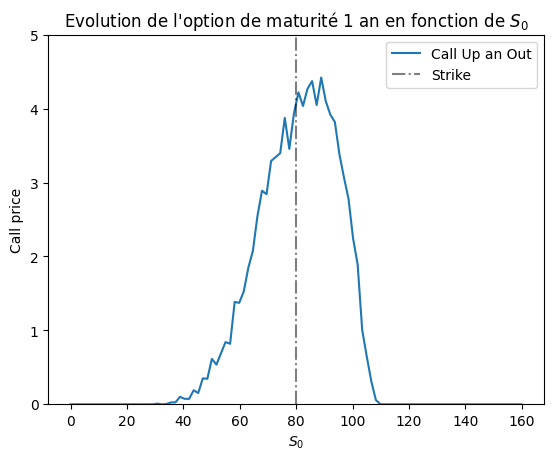

In [166]:
plt.plot(S_0, price_CUO_plots1, label=f"Call Up an Out")


# add strike on the plot
plt.vlines(x=K, ymin=0., ymax=60., color="black",
           label="Strike", linestyles="dashdot", alpha=.5)
plt.ylim(0,5)
# add legend
plt.title("Evolution de l'option de maturité 1 an en fonction de $S_0$")
plt.legend()
plt.xlabel("$S_0$")
plt.ylabel("Call price")
plt.show()

In [167]:
# final plots
price_CUO_plots = np.zeros(len(S_0))
price_Lookback_plots = np.zeros(len(S_0))
price_european_plots = np.zeros(len(S_0))

# compute values
for i, s in enumerate(S_0):
        # compute phi for each sample
        price_CUO_plots[i] = np.mean(phi_price_CUO(S_0=s,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path,barrier=barrier))
        price_Lookback_plots[i] =np.mean(phi_price_Lookback_float(S_0=s,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path))
        price_european_plots[i] = price_european_call(S_0=s,sigma=sigma,r=r,T=T)

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_48100/1821510573.py:19: RuntimeWarning: divide by zero encountered in log
  d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)


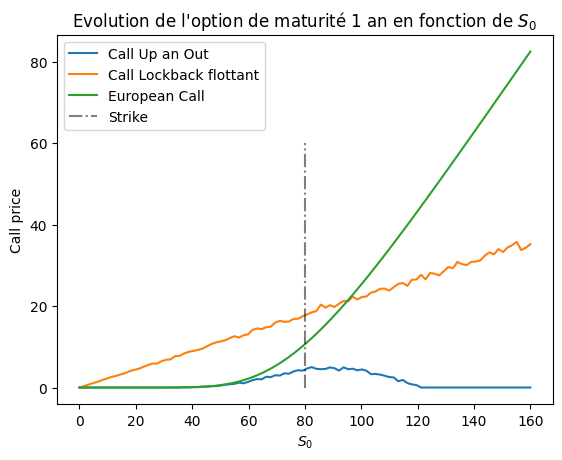

In [168]:
plt.plot(S_0, price_CUO_plots, label=f"Call Up an Out")
plt.plot(S_0, price_Lookback_plots, label=f"Call Lockback flottant")
plt.plot(S_0, price_european_plots, label=f"European Call")


# add strike on the plot
plt.vlines(x=K, ymin=0., ymax=60., color="black",
           label="Strike", linestyles="dashdot", alpha=.5)
# plt.ylim(0,5)
# add legend
plt.title("Evolution de l'option de maturité 1 an en fonction de $S_0$")
plt.legend()
plt.xlabel("$S_0$")
plt.ylabel("Call price")
plt.show()

Le call lookback flottant est simplement proportionnel à S_0, ce qui est normal compte tenu de son payoff et étant donné que chaque S_t = S_0 * exp(...). La valeur du Call up-and-out a presque la même forme qu'un call européen lorsque nous sommes loin de la barrière, mais diminue rapidement à mesure que nous nous approchons de la barrière.

In [169]:
# Ici j'évalue l'effet de taux négatifs possiblement du à de forts dividendes ou taux de repo

"Let's see what happen if the rates are negative"
price_CUO_plots = np.zeros(len(S_0))
price_Lookback_plots = np.zeros(len(S_0))
price_european_plots = np.zeros(len(S_0))

# compute values
for i, s in enumerate(S_0):
        # compute phi for each sample
        price_CUO_plots[i] =np.mean(phi_price_CUO(S_0=s,sigma=sigma,r=-0.05,T=T,N_obs=N_obs,N_path=N_path,barrier=barrier))
        price_Lookback_plots[i] = np.mean(phi_price_Lookback_float(S_0=s,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path))
        price_european_plots[i] = price_european_call(S_0=s,sigma=sigma,r=r,T=T)

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_48100/1821510573.py:19: RuntimeWarning: divide by zero encountered in log
  d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)


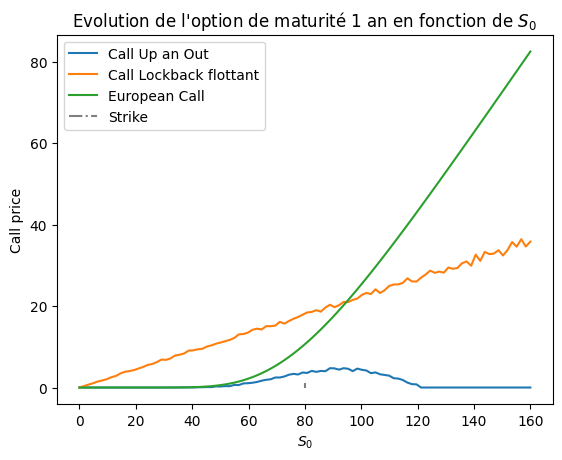

In [171]:
plt.plot(S_0, price_CUO_plots, label=f"Call Up an Out")
plt.plot(S_0, price_Lookback_plots, label=f"Call Lockback flottant")
plt.plot(S_0, price_european_plots, label=f"European Call")


# add strike on the plot
plt.vlines(x=K, ymin=0.,ymax=1.0, color="black",
           label="Strike", linestyles="dashdot", alpha=.5) #

# add legend
plt.title("Evolution de l'option de maturité 1 an en fonction de $S_0$")
plt.legend()
plt.xlabel("$S_0$")
plt.ylabel("Call price")
plt.show()
r=0.03

Il semble que la forme du call up-and-out ne change pas vraiment lorsque les taux d'intérêt sont négatifs. Cependant, la portée de l'option de rachat (lookback call) augmente. On peut expliquer cela par le fait qu'en cas de taux négatifs, le forward S0 * exp(-rT) diminue avec le temps, de sorte que la différence attendue entre max(S_t) et S_T augmente.

### Q2 - Illustrer la convergence du prix Monte Carlo de l’option d’achat à barrière up-and-out (variante discrète) lorsque le nombre de dates d’observation augmente, en comparaison avec le prix Monte Carlo avec un suivi continu de la barrière.


3) Maintenant, nous cherchons à rajouter les intervalles de confiance à chaque itération n pour les rajouter sur notre figure.
Pour cela, nous connaissons la loi asymptotique du pivot: 
$$ R_n = \sqrt{n} \frac{C_n - C_0}{\hat{\sigma_n}} \sim N(0, 1) $$ 

Ainsi, on peut écrire que:
$$ P(q_{\alpha / 2} < R_n < q_{1 - \alpha / 2} ) \approx 1 - \alpha $$
et donc, 
$$ P(\frac{q_{\alpha / 2}\times \hat{\sigma_n}}{\sqrt{n}} + C_n < C_0 < \frac{q_{1 - \alpha / 2} \times \hat{\sigma_n}}{\sqrt{n}} + C_n ) \approx 1 - \alpha $$ 

In [172]:
# compute estimation and std for every n
N_obs_values=np.linspace(1,1501,500)
estimations = np.zeros_like(N_obs_values)
std_estimations = np.zeros_like(N_obs_values)

for i, n_obs in enumerate(N_obs_values):
    phi_samples = phi_price_CUO(S_0=90,N_obs=int(n_obs))
    estimations[i] = np.mean(phi_samples)
    std_estimations[i] = np.std(phi_samples,ddof=1)

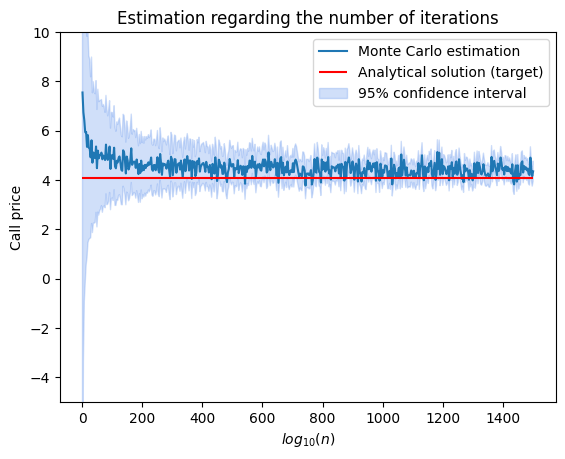

In [173]:
# compute quantiles
q = stats.norm.interval(.95, loc=mean, scale=std)[1]

# compute confidence interval
c_i = q*np.divide(std_estimations, np.sqrt(N_obs_values))

# plot esimtations
plt.plot(N_obs_values, estimations, alpha=1, label="Monte Carlo estimation")
plt.ylim(-5,10)
# plot target
target=np.mean(phi_price_CUO_Continu(S_0=90,N_sim_max=5000))
plt.hlines(y=target, xmin=0, xmax=1501, color="red", label="Analytical solution (target)")
# plt.hlines(y=target, xmin=2, xmax=6, color="red", label="Analytical solution (target)")

# plot confidence interval
plt.fill_between(N_obs_values, (estimations-c_i), (estimations+c_i), 
                 label="95% confidence interval", color="cornflowerblue", alpha=0.3)

# add legend and title
plt.title("Estimation regarding the number of iterations")
plt.xlabel("$log_{10}(n)$")
plt.ylabel("Call price")
plt.legend()
plt.show()


It seems that the price of the CUO converge to a certain value ( ~4 ) when the price of number of observations dates reach +infinity

### Q3 - Illustrer la convergence du prix Monte Carlo de l’option d’achat lookback à strike flottant (variante discrète) avec l'augmentation du nombre de dates d'observation vers le prix Monte Carlo avec un suivi continu du maximum.


In [174]:
# compute estimation and std for every n
N_obs_values=np.linspace(1,1501,500)
estimations = np.zeros_like(N_obs_values)
std_estimations = np.zeros_like(N_obs_values)

for i, n_obs in enumerate(N_obs_values):
    phi_samples = phi_price_Lookback_float(S_0=100,r=.03,N_obs=int(n_obs))
    estimations[i] = np.mean(phi_samples)
    std_estimations[i] = np.std(phi_samples,ddof=1)

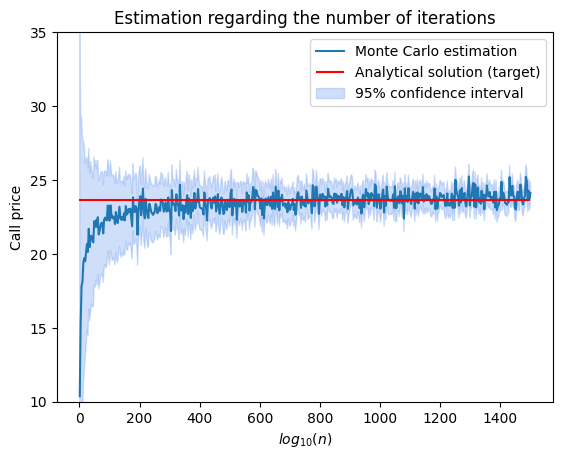

In [177]:
# compute quantiles
q = stats.norm.interval(.95, loc=mean, scale=std)[1]

# compute confidence interval
c_i = q*np.divide(std_estimations, np.sqrt(N_obs_values))

# plot esimtations
plt.plot(N_obs_values, estimations, alpha=1, label="Monte Carlo estimation")
plt.ylim(10,35)
# plot target
target=np.mean(phi_price_Lookback_float_Continu(S_0=100,N_sim_max=5000)[0])
plt.hlines(y=target, xmin=0, xmax=1501, color="red", label="Analytical solution (target)")

# plot confidence interval
plt.fill_between(N_obs_values, (estimations-c_i), (estimations+c_i), 
                 label="95% confidence interval", color="cornflowerblue", alpha=0.3)

# add legend and title
plt.title("Estimation regarding the number of iterations")
plt.xlabel("$log_{10}(n)$")
plt.ylabel("Call price")
plt.legend()
plt.show()

### Q4. Proposition d'une évaluation par EDP de l'option d'achat lookback à strike flottant et analyse des résultats (convergence, lien avec Monte Carlo).


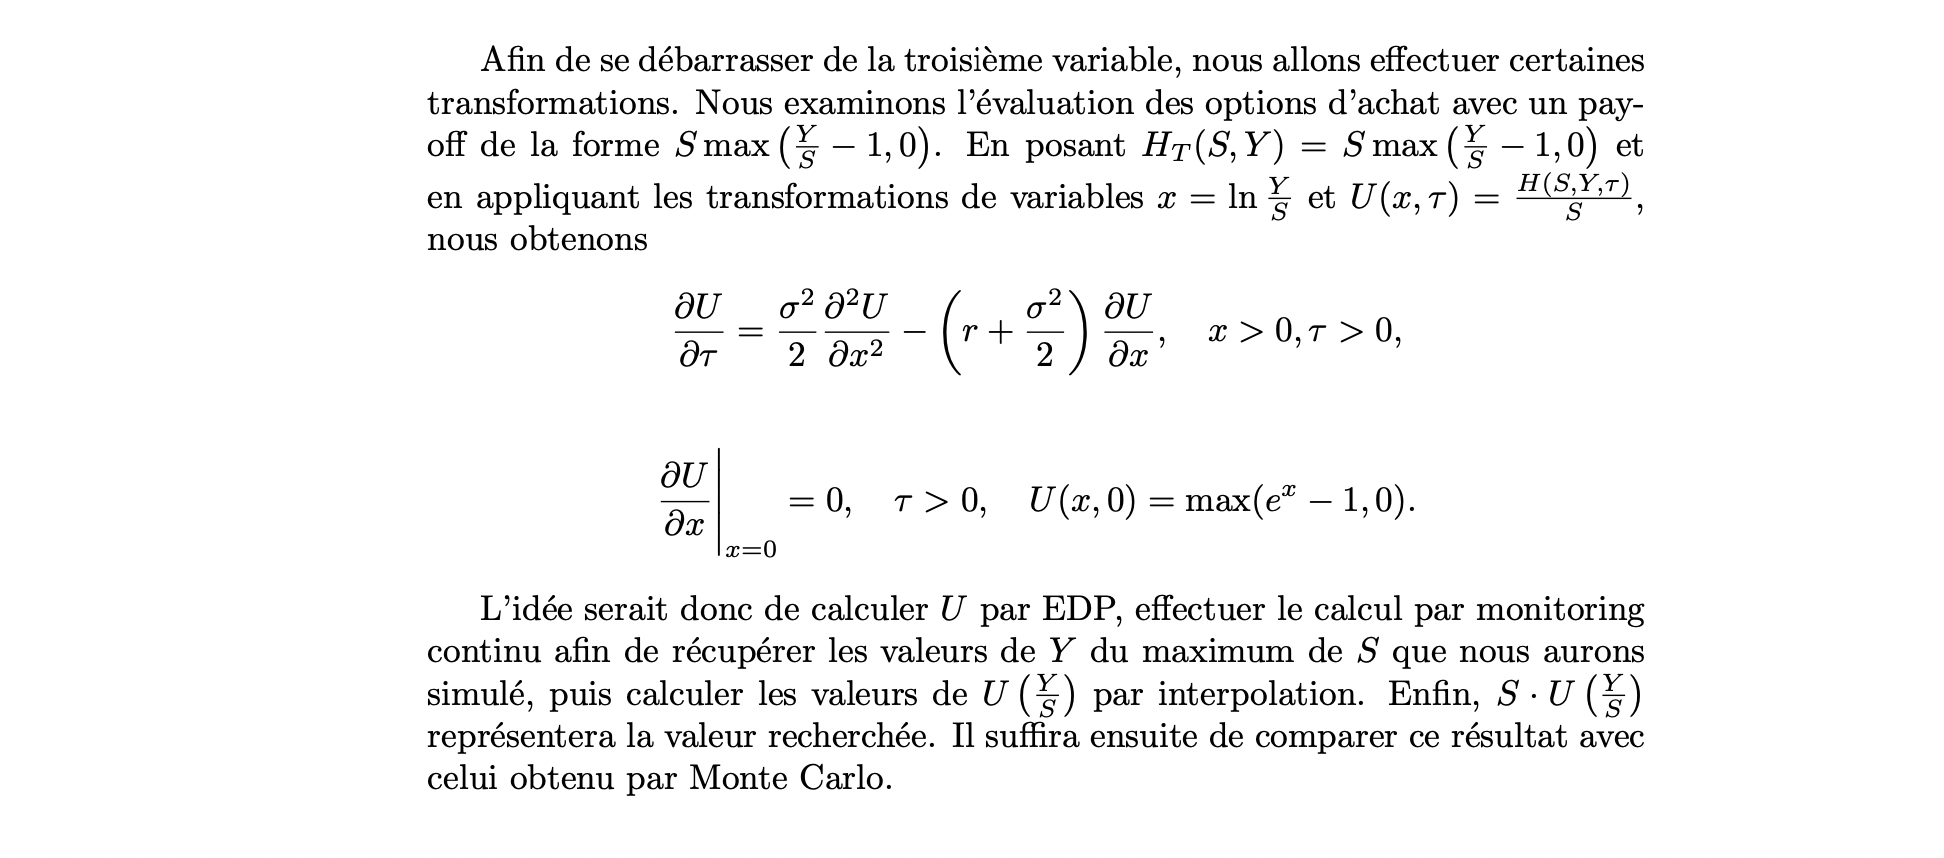

In [178]:
# about PDE
M = 252  # nb of time points
N = 4000  # nb of space points
L = 2  # space limits for PDE

In [180]:
def construct_A_matrix(sigma, h, r):
    # return values on tridiagonal

    a = (sigma**2/2)/(h**2) - (r + sigma**2 / 2)/(2*h)
    b = - (sigma/h)**2
    c = (sigma**2/2)/(h**2) + (r + sigma**2 / 2)/(2*h)

    return a, b, c



def EDP(K, T, sigma, r, M, N, L, method="euler-explicite"):
    """
    Function to solve PDE.
    """

    ### initalization 

    # definition of steps
    h = L / N  # space step 
    delta_t = T / M  # time step

    # definition of A matrix
    a,b,c = construct_A_matrix(sigma, h, r)
    
    #U(x,t)
    # initialisation of U matrix
    max_div_S = np.arange(N+1)*h
    x=np.log(max_div_S)
    
    U = np.zeros(shape=(N+1, M+1))
    U[:,0]=np.exp(x)-1 # Check si t'as bien 0
    U[0,0]=U[1,0]
   
    ### compute time t+1 using time t 
    A = a*np.eye(N=N-1, k=-1) + b*np.eye(N=N-1) + c*np.eye(N=N-1, k=1) 
        ### Method = euler implicite  ###
    if method == "euler-implicite":     # definition of transition matrix
        
        transition_matrix = np.linalg.inv(np.eye(N-1) - delta_t * A)
    
        # compute all columns of U
        for i in range(1, M+1):
    
            # compute i-th column
            U[1:N, i] = np.matmul(transition_matrix, U[1:N, i-1])
            U[0,i]=U[1,i]
    
    elif method == "Crank-Nicholson":
        # definition of transition matrix
        transition_matrix = np.linalg.inv(np.eye(N-1) - 0.5*delta_t * A)

        # compute all columns of U
        for i in range(1, M+1):
            U[1:N, i] = np.matmul(np.matmul(transition_matrix,(np.eye(N-1)+(1-0.5)*delta_t*A)), U[1:N, i-1])
            U[0,i]=U[1,i]


    return interp1d(max_div_S, U[:, -1], kind='linear', fill_value='extrapolate')
    
    
    #     return U[:, -1]
    
    # return None

# results = EDP(K, T, sigma, r, M, N, L=2,method="Crank-Nicholson")

In [181]:
# final plots

"Let's see what happen if the rates are negative"
price_Lookback_plots = np.zeros(len(S_0))
values=[]
# compute values
for i, s in enumerate(S_0):
        # compute phi for each sample
        price,maxs=phi_price_Lookback_float_Continu(S_0=s,sigma=sigma,r=r,T=T,N_obs=N_obs,N_path=N_path)
        price_Lookback_plots[i] = np.mean(price)
        values.append(np.mean(maxs)/(s+1e-4))

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_48100/3457093269.py:4: RuntimeWarning: invalid value encountered in divide
  X_T=np.log(S_T/S_0)/sigma


In [182]:
# define values on axis
x = values
# compute PDE-method predictions and actual values
y = EDP(K, T, sigma, r, M, N=N, L=L,method="Crank-Nicholson")(x)
price_option_lookback_EDP=y*S_0


/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_48100/848727006.py:29: RuntimeWarning: divide by zero encountered in log
  x=np.log(max_div_S)


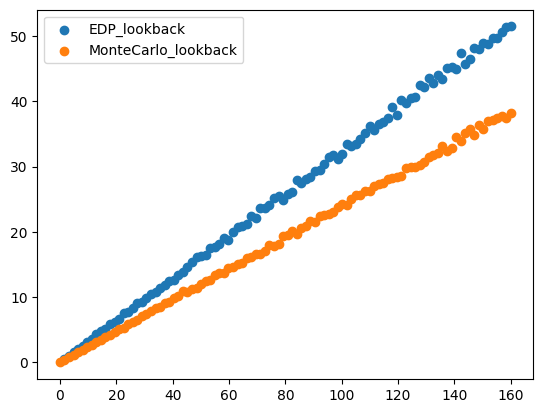

In [183]:
plt.scatter(x=S_0,y=price_option_lookback_EDP,label='EDP_lookback')
plt.scatter(x=S_0, y=price_Lookback_plots, label='MonteCarlo_lookback')
plt.legend()

On constate une divergence au fur et à mesure qu'on se rapproche du bord